In [2]:
import os
import json
import torch
from torch_geometric.data import Dataset, Data

class SingleFileEmbeddingPairDataset(Dataset):
    def __init__(self, json_path):
        super().__init__(os.path.dirname(json_path))
        # Load the JSON (which is a dict of model numbers)
        with open(json_path, 'r') as f:
            model_dict = json.load(f)
            # Flatten all model pairs into a list:
            self.all_pairs = []
            for model_num, pair in model_dict.items():
                # Optionally store model_num if you want it later: pair['model_num'] = model_num
                self.all_pairs.append(pair)

    def __len__(self):
        return len(self.all_pairs)

    def __getitem__(self, idx):
        pair = self.all_pairs[idx]

        # Extract embeddings for A and B
        A_ids = sorted(pair['A_embeddings'].keys(), key=lambda x: int(x))
        xA = torch.tensor([pair['A_embeddings'][xtid] for xtid in A_ids], dtype=torch.float)
        B_ids = sorted(pair['B_embeddings'].keys(), key=lambda x: int(x))
        xB = torch.tensor([pair['B_embeddings'][xtid] for xtid in B_ids], dtype=torch.float)

        # Dummy edge indices (empty for now)
        edge_indexA = torch.empty((2,0), dtype=torch.long)
        edge_indexB = torch.empty((2,0), dtype=torch.long)

        A_id_to_idx = {int(aid): idx for idx, aid in enumerate(A_ids)}
        B_id_to_idx = {int(bid): idx for idx, bid in enumerate(B_ids)}

        mappings = []
        for a, b in pair['mappings']:
            idx_a = -1 if a == 'NULL' else A_id_to_idx[int(a)]  
            idx_b = -1 if b == 'NULL' else B_id_to_idx[int(b)]
            mappings.append([idx_a, idx_b])

        matches = torch.tensor(mappings, dtype=torch.long)

        dataA = Data(x=xA, edge_index=edge_indexA, xt_entity_ids=A_ids)
        dataB = Data(x=xB, edge_index=edge_indexB, xt_entity_ids=B_ids)
        return dataA, dataB, matches

In [ ]:
import torch.nn as nn 
import torch.nn.functional as F 
from torch_geometric.nn import SAGEConv 
class GraphEncoder(nn.Module): 
    def __init__(self, input_dim, hidden_dim, out_dim): 
        super().__init__() 
        self.conv1 = SAGEConv(input_dim, hidden_dim) 
        self.conv2 = SAGEConv(hidden_dim, hidden_dim) 
        self.conv3 = SAGEConv(hidden_dim, out_dim) 
    def forward(self, x, edge_index): 
        x = F.relu(self.conv1(x, edge_index)) 
        x = F.relu(self.conv2(x, edge_index)) 
        x = self.conv3(x, edge_index) 
        return x 
class SiameseGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim): 
        super().__init__() 
        self.encoder = GraphEncoder(in_dim, hidden_dim, out_dim) 
    def forward(self, data1, data2): 
        h1 = self.encoder(data1.x, data1.edge_index) # [N1, out_dim] 
        h2 = self.encoder(data2.x, data2.edge_index) # [N2, out_dim]
        h1 = F.normalize(h1, p=2, dim=1)
        h2 = F.normalize(h2, p=2, dim=1)

        return h1, h2

In [4]:
import torch
import torch.nn.functional as F

# --- Core Contrastive Margin Loss ---
def contrastive_margin_loss(emb1, emb2, matches_pos, matches_neg, margin=1.0):
    """
    emb1: [N1, D]
    emb2: [N2, D]
    matches_pos: [K1, 2]  -> positive pairs (valid correspondences)
    matches_neg: [K2, 2]  -> negative pairs (non-correspondences)
    margin: margin distance for negatives
    """
    if matches_pos.numel() == 0:
        # No positives in this batch → zero loss but keep graph
        return (emb1.sum() * 0.0) + (emb2.sum() * 0.0)

    # ---- Positive loss (want small distances) ----
    pos1 = emb1[matches_pos[:, 0]]
    pos2 = emb2[matches_pos[:, 1]]
    pos_dist = (pos1 - pos2).pow(2).sum(dim=1)
    pos_loss = pos_dist.mean()

    # ---- Negative loss (want large distances > margin) ----
    if matches_neg.numel() == 0:
        neg_loss = torch.tensor(0.0, device=emb1.device)
    else:
        neg1 = emb1[matches_neg[:, 0]]
        neg2 = emb2[matches_neg[:, 1]]
        neg_dist = (neg1 - neg2).pow(2).sum(dim=1)
        neg_loss = F.relu(margin - neg_dist).mean()

    return pos_loss + neg_loss


# --- Random negative sampling ---
def get_random_negatives(matches_pos, emb1_size, emb2_size, num_neg=None):
    num_pos = matches_pos.size(0)
    num_neg = num_neg or num_pos

    rand_A = torch.randint(0, emb1_size, (num_neg,))
    rand_B = torch.randint(0, emb2_size, (num_neg,))
    mask = torch.ones(num_neg, dtype=torch.bool)
    pos_set = set(map(tuple, matches_pos.tolist()))
    for i in range(num_neg):
        if (rand_A[i].item(), rand_B[i].item()) in pos_set:
            mask[i] = False
    return torch.stack([rand_A[mask], rand_B[mask]], dim=1)


# --- Hard negative sampling ---
def get_hard_negatives(emb1, emb2, matches_pos, top_k=3):
    """
    Select hardest negatives (closest embeddings not in positive set)
    """
    with torch.no_grad():
        dist = torch.cdist(emb1, emb2, p=2)  # [N1, N2]
        pos_mask = torch.zeros_like(dist, dtype=torch.bool)
        pos_mask[matches_pos[:, 0], matches_pos[:, 1]] = True
        dist[pos_mask] = 1e6  # mask out positives

        # Select top-k smallest distances as negatives
        neg_indices = dist.topk(k=top_k, largest=False).indices  # [N1, top_k]
        matches_neg = []
        for i in range(neg_indices.size(0)):
            for j in neg_indices[i]:
                matches_neg.append([i, j.item()])
        matches_neg = torch.tensor(matches_neg, dtype=torch.long, device=emb1.device)
    return matches_neg


# --- Mixed negative sampling (recommended) ---
def get_mixed_negatives(emb1, emb2, matches_pos, ratio=0.5, top_k=3):
    """
    Combines random + hard negatives
    """
    hard_negs = get_hard_negatives(emb1, emb2, matches_pos, top_k)
    rand_negs = get_random_negatives(matches_pos, emb1.size(0), emb2.size(0))
    num_hard = int(ratio * min(len(hard_negs), len(rand_negs)))
    if num_hard == 0:
        return rand_negs
    mixed = torch.cat([hard_negs[:num_hard], rand_negs[:num_hard]], dim=0)
    return mixed



In [5]:
def batch_accuracy(emb1, emb2, matches):
    # emb1: [N1, D], emb2: [N2, D], matches: [K,2]
    valid = matches[:,1] != -1
    indices1 = matches[valid, 0]
    indices2 = matches[valid, 1]

    if len(indices1) == 0:
        return None  # avoid NaN

    dists = torch.cdist(emb1, emb2)  # [N1, N2]
    # For each ground-truth emb1 index, which emb2 is closest
    min_indices = torch.argmin(dists[indices1], dim=1)
    correct = (min_indices == indices2).float()
    return correct.mean().item()

In [6]:
def batch_topk_accuracy(emb1, emb2, matches, k=5):
    valid = matches[:,1] != -1
    indices1 = matches[valid, 0]
    indices2 = matches[valid, 1]

    if len(indices1) == 0:
        return None

    dists = torch.cdist(emb1, emb2)

    actual_k = min(k, emb2.shape[0])
    if actual_k == 0:
        return None  # no candidates

    topk = torch.topk(-dists[indices1], actual_k, dim=1).indices
    correct = torch.any(topk == indices2.unsqueeze(1), dim=1).float()
    return correct.mean().item()

Found 134 dataset entries.
Using device: cpu


Epoch 1: 100%|██████████| 134/134 [00:00<00:00, 147.52it/s]


Epoch 001: Loss = 2.0117, Top-1 = 24.22%, Top-5 = 59.39%


Epoch 2: 100%|██████████| 134/134 [00:00<00:00, 144.37it/s]


Epoch 002: Loss = 0.8076, Top-1 = 25.58%, Top-5 = 61.17%


Epoch 3: 100%|██████████| 134/134 [00:00<00:00, 179.80it/s]


Epoch 003: Loss = 0.7781, Top-1 = 25.55%, Top-5 = 61.09%


Epoch 4: 100%|██████████| 134/134 [00:00<00:00, 175.79it/s]


Epoch 004: Loss = 0.7517, Top-1 = 25.99%, Top-5 = 61.87%


Epoch 5: 100%|██████████| 134/134 [00:00<00:00, 176.95it/s]


Epoch 005: Loss = 0.7456, Top-1 = 26.19%, Top-5 = 61.75%


Epoch 6: 100%|██████████| 134/134 [00:00<00:00, 183.12it/s]


Epoch 006: Loss = 0.7365, Top-1 = 26.62%, Top-5 = 61.97%


Epoch 7: 100%|██████████| 134/134 [00:00<00:00, 168.07it/s]


Epoch 007: Loss = 0.7267, Top-1 = 26.71%, Top-5 = 61.75%


Epoch 8: 100%|██████████| 134/134 [00:00<00:00, 179.86it/s]


Epoch 008: Loss = 0.7296, Top-1 = 26.11%, Top-5 = 61.62%


Epoch 9: 100%|██████████| 134/134 [00:00<00:00, 180.05it/s]


Epoch 009: Loss = 0.7076, Top-1 = 26.69%, Top-5 = 61.72%


Epoch 10: 100%|██████████| 134/134 [00:00<00:00, 178.72it/s]


Epoch 010: Loss = 0.7058, Top-1 = 27.17%, Top-5 = 62.22%


Epoch 11: 100%|██████████| 134/134 [00:00<00:00, 184.12it/s]


Epoch 011: Loss = 0.7035, Top-1 = 26.85%, Top-5 = 62.35%


Epoch 12: 100%|██████████| 134/134 [00:00<00:00, 171.51it/s]


Epoch 012: Loss = 0.7026, Top-1 = 27.11%, Top-5 = 62.24%


Epoch 13: 100%|██████████| 134/134 [00:00<00:00, 178.12it/s]


Epoch 013: Loss = 0.6918, Top-1 = 26.48%, Top-5 = 62.47%


Epoch 14: 100%|██████████| 134/134 [00:00<00:00, 167.02it/s]


Epoch 014: Loss = 0.6881, Top-1 = 26.93%, Top-5 = 62.42%


Epoch 15: 100%|██████████| 134/134 [00:00<00:00, 178.24it/s]


Epoch 015: Loss = 0.6807, Top-1 = 26.84%, Top-5 = 62.24%


Epoch 16: 100%|██████████| 134/134 [00:00<00:00, 181.87it/s]


Epoch 016: Loss = 0.6842, Top-1 = 26.91%, Top-5 = 62.31%


Epoch 17: 100%|██████████| 134/134 [00:00<00:00, 184.00it/s]


Epoch 017: Loss = 0.6693, Top-1 = 27.41%, Top-5 = 63.08%


Epoch 18: 100%|██████████| 134/134 [00:00<00:00, 177.05it/s]


Epoch 018: Loss = 0.6665, Top-1 = 27.16%, Top-5 = 63.17%


Epoch 19: 100%|██████████| 134/134 [00:00<00:00, 180.89it/s]


Epoch 019: Loss = 0.6762, Top-1 = 26.95%, Top-5 = 62.60%


Epoch 20: 100%|██████████| 134/134 [00:00<00:00, 167.54it/s]


Epoch 020: Loss = 0.6684, Top-1 = 26.66%, Top-5 = 63.19%


Epoch 21: 100%|██████████| 134/134 [00:00<00:00, 179.92it/s]


Epoch 021: Loss = 0.6618, Top-1 = 27.07%, Top-5 = 63.12%


Epoch 22: 100%|██████████| 134/134 [00:00<00:00, 185.54it/s]


Epoch 022: Loss = 0.6620, Top-1 = 26.70%, Top-5 = 62.86%


Epoch 23: 100%|██████████| 134/134 [00:00<00:00, 181.63it/s]


Epoch 023: Loss = 0.6640, Top-1 = 26.60%, Top-5 = 63.00%


Epoch 24: 100%|██████████| 134/134 [00:00<00:00, 179.69it/s]


Epoch 024: Loss = 0.6605, Top-1 = 26.32%, Top-5 = 63.14%


Epoch 25: 100%|██████████| 134/134 [00:00<00:00, 177.06it/s]


Epoch 025: Loss = 0.6563, Top-1 = 26.11%, Top-5 = 63.62%


Epoch 26: 100%|██████████| 134/134 [00:00<00:00, 161.78it/s]


Epoch 026: Loss = 0.6543, Top-1 = 26.71%, Top-5 = 63.51%


Epoch 27: 100%|██████████| 134/134 [00:00<00:00, 175.79it/s]


Epoch 027: Loss = 0.6632, Top-1 = 27.12%, Top-5 = 63.15%


Epoch 28: 100%|██████████| 134/134 [00:00<00:00, 179.92it/s]


Epoch 028: Loss = 0.6648, Top-1 = 26.83%, Top-5 = 62.74%


Epoch 29: 100%|██████████| 134/134 [00:00<00:00, 166.09it/s]


Epoch 029: Loss = 0.6575, Top-1 = 27.00%, Top-5 = 62.98%


Epoch 30: 100%|██████████| 134/134 [00:00<00:00, 146.39it/s]


Epoch 030: Loss = 0.6647, Top-1 = 27.08%, Top-5 = 63.44%


Epoch 31: 100%|██████████| 134/134 [00:00<00:00, 168.16it/s]


Epoch 031: Loss = 0.6525, Top-1 = 27.18%, Top-5 = 63.72%


Epoch 32: 100%|██████████| 134/134 [00:00<00:00, 167.52it/s]


Epoch 032: Loss = 0.6480, Top-1 = 27.46%, Top-5 = 63.24%


Epoch 33: 100%|██████████| 134/134 [00:00<00:00, 167.65it/s]


Epoch 033: Loss = 0.6508, Top-1 = 27.04%, Top-5 = 63.29%


Epoch 34: 100%|██████████| 134/134 [00:00<00:00, 170.96it/s]


Epoch 034: Loss = 0.6461, Top-1 = 26.92%, Top-5 = 63.67%


Epoch 35: 100%|██████████| 134/134 [00:00<00:00, 175.34it/s]


Epoch 035: Loss = 0.6506, Top-1 = 27.32%, Top-5 = 63.46%


Epoch 36: 100%|██████████| 134/134 [00:00<00:00, 165.99it/s]


Epoch 036: Loss = 0.6415, Top-1 = 26.98%, Top-5 = 63.42%


Epoch 37: 100%|██████████| 134/134 [00:00<00:00, 178.49it/s]


Epoch 037: Loss = 0.6449, Top-1 = 26.91%, Top-5 = 63.52%


Epoch 38: 100%|██████████| 134/134 [00:00<00:00, 178.59it/s]


Epoch 038: Loss = 0.6570, Top-1 = 25.89%, Top-5 = 62.55%


Epoch 39: 100%|██████████| 134/134 [00:00<00:00, 179.44it/s]


Epoch 039: Loss = 0.6429, Top-1 = 27.44%, Top-5 = 63.75%


Epoch 40: 100%|██████████| 134/134 [00:00<00:00, 175.90it/s]


Epoch 040: Loss = 0.6482, Top-1 = 26.56%, Top-5 = 63.59%


Epoch 41: 100%|██████████| 134/134 [00:00<00:00, 177.89it/s]


Epoch 041: Loss = 0.6394, Top-1 = 27.58%, Top-5 = 64.07%


Epoch 42: 100%|██████████| 134/134 [00:00<00:00, 160.90it/s]


Epoch 042: Loss = 0.6376, Top-1 = 26.77%, Top-5 = 63.67%


Epoch 43: 100%|██████████| 134/134 [00:00<00:00, 176.48it/s]


Epoch 043: Loss = 0.6540, Top-1 = 27.13%, Top-5 = 63.87%


Epoch 44: 100%|██████████| 134/134 [00:00<00:00, 179.68it/s]


Epoch 044: Loss = 0.6442, Top-1 = 26.72%, Top-5 = 63.62%


Epoch 45: 100%|██████████| 134/134 [00:00<00:00, 175.44it/s]


Epoch 045: Loss = 0.6463, Top-1 = 27.48%, Top-5 = 63.63%


Epoch 46: 100%|██████████| 134/134 [00:00<00:00, 176.22it/s]


Epoch 046: Loss = 0.6380, Top-1 = 27.36%, Top-5 = 64.30%


Epoch 47: 100%|██████████| 134/134 [00:00<00:00, 180.16it/s]


Epoch 047: Loss = 0.6391, Top-1 = 26.96%, Top-5 = 63.77%


Epoch 48: 100%|██████████| 134/134 [00:00<00:00, 164.06it/s]


Epoch 048: Loss = 0.6399, Top-1 = 27.21%, Top-5 = 64.10%


Epoch 49: 100%|██████████| 134/134 [00:00<00:00, 174.18it/s]


Epoch 049: Loss = 0.6277, Top-1 = 28.21%, Top-5 = 63.81%


Epoch 50: 100%|██████████| 134/134 [00:00<00:00, 174.42it/s]


Epoch 050: Loss = 0.6305, Top-1 = 28.10%, Top-5 = 64.13%


Epoch 51: 100%|██████████| 134/134 [00:00<00:00, 159.34it/s]


Epoch 051: Loss = 0.6446, Top-1 = 26.59%, Top-5 = 63.33%


Epoch 52: 100%|██████████| 134/134 [00:00<00:00, 175.10it/s]


Epoch 052: Loss = 0.6292, Top-1 = 28.17%, Top-5 = 64.37%


Epoch 53: 100%|██████████| 134/134 [00:00<00:00, 175.44it/s]


Epoch 053: Loss = 0.6412, Top-1 = 26.55%, Top-5 = 63.81%


Epoch 54: 100%|██████████| 134/134 [00:00<00:00, 145.92it/s]


Epoch 054: Loss = 0.6348, Top-1 = 26.68%, Top-5 = 63.84%


Epoch 55: 100%|██████████| 134/134 [00:00<00:00, 173.18it/s]


Epoch 055: Loss = 0.6359, Top-1 = 27.81%, Top-5 = 63.75%


Epoch 56: 100%|██████████| 134/134 [00:00<00:00, 173.51it/s]


Epoch 056: Loss = 0.6289, Top-1 = 28.50%, Top-5 = 64.26%


Epoch 57: 100%|██████████| 134/134 [00:00<00:00, 160.42it/s]


Epoch 057: Loss = 0.6263, Top-1 = 28.33%, Top-5 = 64.21%


Epoch 58: 100%|██████████| 134/134 [00:00<00:00, 177.65it/s]


Epoch 058: Loss = 0.6269, Top-1 = 28.58%, Top-5 = 63.89%


Epoch 59: 100%|██████████| 134/134 [00:00<00:00, 176.02it/s]


Epoch 059: Loss = 0.6342, Top-1 = 28.59%, Top-5 = 64.58%


Epoch 60: 100%|██████████| 134/134 [00:00<00:00, 175.90it/s]


Epoch 060: Loss = 0.6200, Top-1 = 27.90%, Top-5 = 63.60%


Epoch 61: 100%|██████████| 134/134 [00:00<00:00, 170.96it/s]


Epoch 061: Loss = 0.6171, Top-1 = 28.02%, Top-5 = 63.87%


Epoch 62: 100%|██████████| 134/134 [00:00<00:00, 175.10it/s]


Epoch 062: Loss = 0.6159, Top-1 = 28.71%, Top-5 = 64.56%


Epoch 63: 100%|██████████| 134/134 [00:00<00:00, 165.01it/s]


Epoch 063: Loss = 0.6138, Top-1 = 28.68%, Top-5 = 64.58%


Epoch 64: 100%|██████████| 134/134 [00:00<00:00, 154.14it/s]


Epoch 064: Loss = 0.6203, Top-1 = 28.57%, Top-5 = 64.58%


Epoch 65: 100%|██████████| 134/134 [00:00<00:00, 178.01it/s]


Epoch 065: Loss = 0.6260, Top-1 = 28.62%, Top-5 = 64.55%


Epoch 66: 100%|██████████| 134/134 [00:00<00:00, 178.48it/s]


Epoch 066: Loss = 0.6181, Top-1 = 28.00%, Top-5 = 64.17%


Epoch 67: 100%|██████████| 134/134 [00:00<00:00, 174.16it/s]


Epoch 067: Loss = 0.6161, Top-1 = 28.90%, Top-5 = 64.45%


Epoch 68: 100%|██████████| 134/134 [00:00<00:00, 169.02it/s]


Epoch 068: Loss = 0.6273, Top-1 = 28.57%, Top-5 = 64.06%


Epoch 69: 100%|██████████| 134/134 [00:00<00:00, 172.95it/s]


Epoch 069: Loss = 0.6146, Top-1 = 28.65%, Top-5 = 64.04%


Epoch 70: 100%|██████████| 134/134 [00:00<00:00, 166.49it/s]


Epoch 070: Loss = 0.6271, Top-1 = 28.36%, Top-5 = 64.87%


Epoch 71: 100%|██████████| 134/134 [00:00<00:00, 157.12it/s]


Epoch 071: Loss = 0.6160, Top-1 = 28.86%, Top-5 = 64.78%


Epoch 72: 100%|██████████| 134/134 [00:00<00:00, 175.78it/s]


Epoch 072: Loss = 0.6189, Top-1 = 29.13%, Top-5 = 64.20%


Epoch 73: 100%|██████████| 134/134 [00:00<00:00, 179.43it/s]


Epoch 073: Loss = 0.6089, Top-1 = 28.52%, Top-5 = 64.17%


Epoch 74: 100%|██████████| 134/134 [00:00<00:00, 177.41it/s]


Epoch 074: Loss = 0.6087, Top-1 = 28.63%, Top-5 = 64.34%


Epoch 75: 100%|██████████| 134/134 [00:00<00:00, 172.18it/s]


Epoch 075: Loss = 0.6096, Top-1 = 28.33%, Top-5 = 64.39%


Epoch 76: 100%|██████████| 134/134 [00:00<00:00, 173.40it/s]


Epoch 076: Loss = 0.6063, Top-1 = 28.92%, Top-5 = 64.70%


Epoch 77: 100%|██████████| 134/134 [00:00<00:00, 159.28it/s]


Epoch 077: Loss = 0.6094, Top-1 = 28.46%, Top-5 = 64.47%


Epoch 78: 100%|██████████| 134/134 [00:00<00:00, 177.78it/s]


Epoch 078: Loss = 0.6105, Top-1 = 28.66%, Top-5 = 64.94%


Epoch 79: 100%|██████████| 134/134 [00:00<00:00, 174.87it/s]


Epoch 079: Loss = 0.6124, Top-1 = 28.42%, Top-5 = 63.90%


Epoch 80: 100%|██████████| 134/134 [00:00<00:00, 182.49it/s]


Epoch 080: Loss = 0.6082, Top-1 = 28.61%, Top-5 = 64.26%


Epoch 81: 100%|██████████| 134/134 [00:00<00:00, 162.05it/s]


Epoch 081: Loss = 0.6151, Top-1 = 27.94%, Top-5 = 64.95%


Epoch 82: 100%|██████████| 134/134 [00:00<00:00, 163.36it/s]


Epoch 082: Loss = 0.6085, Top-1 = 28.70%, Top-5 = 64.51%


Epoch 83: 100%|██████████| 134/134 [00:00<00:00, 177.18it/s]


Epoch 083: Loss = 0.5965, Top-1 = 28.66%, Top-5 = 64.35%


Epoch 84: 100%|██████████| 134/134 [00:00<00:00, 179.92it/s]


Epoch 084: Loss = 0.6200, Top-1 = 28.75%, Top-5 = 63.78%


Epoch 85: 100%|██████████| 134/134 [00:00<00:00, 157.11it/s]


Epoch 085: Loss = 0.6090, Top-1 = 28.72%, Top-5 = 64.00%


Epoch 86: 100%|██████████| 134/134 [00:00<00:00, 164.09it/s]


Epoch 086: Loss = 0.6169, Top-1 = 29.05%, Top-5 = 64.62%


Epoch 87: 100%|██████████| 134/134 [00:00<00:00, 173.40it/s]


Epoch 087: Loss = 0.6051, Top-1 = 29.91%, Top-5 = 64.48%


Epoch 88: 100%|██████████| 134/134 [00:00<00:00, 175.38it/s]


Epoch 088: Loss = 0.6206, Top-1 = 29.54%, Top-5 = 64.67%


Epoch 89: 100%|██████████| 134/134 [00:00<00:00, 170.85it/s]


Epoch 089: Loss = 0.6147, Top-1 = 29.29%, Top-5 = 64.71%


Epoch 90: 100%|██████████| 134/134 [00:00<00:00, 171.04it/s]


Epoch 090: Loss = 0.6088, Top-1 = 28.93%, Top-5 = 64.61%


Epoch 91: 100%|██████████| 134/134 [00:00<00:00, 175.79it/s]


Epoch 091: Loss = 0.6058, Top-1 = 29.01%, Top-5 = 64.48%


Epoch 92: 100%|██████████| 134/134 [00:00<00:00, 158.99it/s]


Epoch 092: Loss = 0.5928, Top-1 = 29.19%, Top-5 = 64.87%


Epoch 93: 100%|██████████| 134/134 [00:00<00:00, 176.83it/s]


Epoch 093: Loss = 0.6052, Top-1 = 28.27%, Top-5 = 64.19%


Epoch 94: 100%|██████████| 134/134 [00:00<00:00, 164.09it/s]


Epoch 094: Loss = 0.6082, Top-1 = 29.05%, Top-5 = 65.06%


Epoch 95: 100%|██████████| 134/134 [00:00<00:00, 172.05it/s]


Epoch 095: Loss = 0.6086, Top-1 = 29.04%, Top-5 = 64.36%


Epoch 96: 100%|██████████| 134/134 [00:00<00:00, 179.20it/s]


Epoch 096: Loss = 0.6029, Top-1 = 29.36%, Top-5 = 64.56%


Epoch 97: 100%|██████████| 134/134 [00:00<00:00, 143.35it/s]


Epoch 097: Loss = 0.6067, Top-1 = 29.00%, Top-5 = 64.20%


Epoch 98: 100%|██████████| 134/134 [00:00<00:00, 184.01it/s]


Epoch 098: Loss = 0.6043, Top-1 = 29.00%, Top-5 = 64.11%


Epoch 99: 100%|██████████| 134/134 [00:00<00:00, 161.97it/s]


Epoch 099: Loss = 0.6263, Top-1 = 28.93%, Top-5 = 64.88%


Epoch 100: 100%|██████████| 134/134 [00:00<00:00, 178.84it/s]


Epoch 100: Loss = 0.6108, Top-1 = 29.14%, Top-5 = 64.62%


Epoch 101: 100%|██████████| 134/134 [00:00<00:00, 180.13it/s]


Epoch 101: Loss = 0.5987, Top-1 = 28.71%, Top-5 = 64.30%


Epoch 102: 100%|██████████| 134/134 [00:00<00:00, 156.76it/s]


Epoch 102: Loss = 0.5866, Top-1 = 29.01%, Top-5 = 64.67%


Epoch 103: 100%|██████████| 134/134 [00:00<00:00, 177.77it/s]


Epoch 103: Loss = 0.5989, Top-1 = 29.35%, Top-5 = 65.13%


Epoch 104: 100%|██████████| 134/134 [00:00<00:00, 183.00it/s]


Epoch 104: Loss = 0.5960, Top-1 = 29.25%, Top-5 = 65.18%


Epoch 105: 100%|██████████| 134/134 [00:00<00:00, 163.85it/s]


Epoch 105: Loss = 0.5969, Top-1 = 29.26%, Top-5 = 64.80%


Epoch 106: 100%|██████████| 134/134 [00:00<00:00, 173.73it/s]


Epoch 106: Loss = 0.6017, Top-1 = 29.13%, Top-5 = 64.37%


Epoch 107: 100%|██████████| 134/134 [00:00<00:00, 172.50it/s]


Epoch 107: Loss = 0.6047, Top-1 = 28.69%, Top-5 = 64.56%


Epoch 108: 100%|██████████| 134/134 [00:00<00:00, 167.22it/s]


Epoch 108: Loss = 0.6000, Top-1 = 29.25%, Top-5 = 65.40%


Epoch 109: 100%|██████████| 134/134 [00:00<00:00, 176.14it/s]


Epoch 109: Loss = 0.5995, Top-1 = 28.91%, Top-5 = 64.51%


Epoch 110: 100%|██████████| 134/134 [00:00<00:00, 167.33it/s]


Epoch 110: Loss = 0.6034, Top-1 = 28.94%, Top-5 = 65.02%


Epoch 111: 100%|██████████| 134/134 [00:00<00:00, 178.00it/s]


Epoch 111: Loss = 0.5904, Top-1 = 29.32%, Top-5 = 65.31%


Epoch 112: 100%|██████████| 134/134 [00:00<00:00, 171.63it/s]


Epoch 112: Loss = 0.5933, Top-1 = 29.36%, Top-5 = 64.75%


Epoch 113: 100%|██████████| 134/134 [00:00<00:00, 181.63it/s]


Epoch 113: Loss = 0.5939, Top-1 = 29.07%, Top-5 = 65.13%


Epoch 114: 100%|██████████| 134/134 [00:00<00:00, 180.65it/s]


Epoch 114: Loss = 0.5938, Top-1 = 29.29%, Top-5 = 64.94%


Epoch 115: 100%|██████████| 134/134 [00:00<00:00, 177.42it/s]


Epoch 115: Loss = 0.5957, Top-1 = 29.63%, Top-5 = 64.90%


Epoch 116: 100%|██████████| 134/134 [00:00<00:00, 183.74it/s]


Epoch 116: Loss = 0.5848, Top-1 = 29.42%, Top-5 = 65.11%


Epoch 117: 100%|██████████| 134/134 [00:00<00:00, 179.20it/s]


Epoch 117: Loss = 0.5922, Top-1 = 29.70%, Top-5 = 64.91%


Epoch 118: 100%|██████████| 134/134 [00:00<00:00, 164.42it/s]


Epoch 118: Loss = 0.5867, Top-1 = 29.34%, Top-5 = 64.81%


Epoch 119: 100%|██████████| 134/134 [00:00<00:00, 181.38it/s]


Epoch 119: Loss = 0.6019, Top-1 = 29.55%, Top-5 = 64.93%


Epoch 120: 100%|██████████| 134/134 [00:00<00:00, 181.02it/s]


Epoch 120: Loss = 0.6017, Top-1 = 29.22%, Top-5 = 64.45%


Epoch 121: 100%|██████████| 134/134 [00:00<00:00, 183.24it/s]


Epoch 121: Loss = 0.5941, Top-1 = 29.71%, Top-5 = 64.70%


Epoch 122: 100%|██████████| 134/134 [00:00<00:00, 181.75it/s]


Epoch 122: Loss = 0.5856, Top-1 = 29.92%, Top-5 = 64.97%


Epoch 123: 100%|██████████| 134/134 [00:00<00:00, 164.76it/s]


Epoch 123: Loss = 0.5954, Top-1 = 29.85%, Top-5 = 65.19%


Epoch 124: 100%|██████████| 134/134 [00:00<00:00, 175.60it/s]


Epoch 124: Loss = 0.5919, Top-1 = 29.06%, Top-5 = 64.25%


Epoch 125: 100%|██████████| 134/134 [00:00<00:00, 179.44it/s]


Epoch 125: Loss = 0.5993, Top-1 = 29.36%, Top-5 = 64.98%


Epoch 126: 100%|██████████| 134/134 [00:00<00:00, 174.75it/s]


Epoch 126: Loss = 0.5998, Top-1 = 29.28%, Top-5 = 64.89%


Epoch 127: 100%|██████████| 134/134 [00:00<00:00, 181.04it/s]


Epoch 127: Loss = 0.5833, Top-1 = 29.49%, Top-5 = 65.34%


Epoch 128: 100%|██████████| 134/134 [00:00<00:00, 177.03it/s]


Epoch 128: Loss = 0.5737, Top-1 = 29.52%, Top-5 = 65.67%


Epoch 129: 100%|██████████| 134/134 [00:00<00:00, 163.96it/s]


Epoch 129: Loss = 0.5840, Top-1 = 29.95%, Top-5 = 65.23%


Epoch 130: 100%|██████████| 134/134 [00:00<00:00, 168.80it/s]


Epoch 130: Loss = 0.5809, Top-1 = 29.73%, Top-5 = 64.90%


Epoch 131: 100%|██████████| 134/134 [00:00<00:00, 162.17it/s]


Epoch 131: Loss = 0.5851, Top-1 = 29.55%, Top-5 = 64.85%


Epoch 132: 100%|██████████| 134/134 [00:00<00:00, 181.75it/s]


Epoch 132: Loss = 0.5910, Top-1 = 29.77%, Top-5 = 65.52%


Epoch 133: 100%|██████████| 134/134 [00:00<00:00, 145.81it/s]


Epoch 133: Loss = 0.5877, Top-1 = 29.47%, Top-5 = 64.99%


Epoch 134: 100%|██████████| 134/134 [00:00<00:00, 180.28it/s]


Epoch 134: Loss = 0.5933, Top-1 = 29.37%, Top-5 = 65.56%


Epoch 135: 100%|██████████| 134/134 [00:00<00:00, 162.66it/s]


Epoch 135: Loss = 0.5985, Top-1 = 29.52%, Top-5 = 65.40%


Epoch 136: 100%|██████████| 134/134 [00:00<00:00, 172.40it/s]


Epoch 136: Loss = 0.5832, Top-1 = 29.52%, Top-5 = 65.63%


Epoch 137: 100%|██████████| 134/134 [00:00<00:00, 166.19it/s]


Epoch 137: Loss = 0.5997, Top-1 = 29.48%, Top-5 = 65.21%


Epoch 138: 100%|██████████| 134/134 [00:00<00:00, 165.06it/s]


Epoch 138: Loss = 0.5865, Top-1 = 29.82%, Top-5 = 64.31%


Epoch 139: 100%|██████████| 134/134 [00:00<00:00, 172.84it/s]


Epoch 139: Loss = 0.5807, Top-1 = 29.94%, Top-5 = 65.91%


Epoch 140: 100%|██████████| 134/134 [00:00<00:00, 170.64it/s]


Epoch 140: Loss = 0.5909, Top-1 = 29.88%, Top-5 = 64.99%


Epoch 141: 100%|██████████| 134/134 [00:00<00:00, 165.27it/s]


Epoch 141: Loss = 0.5885, Top-1 = 30.34%, Top-5 = 65.91%


Epoch 142: 100%|██████████| 134/134 [00:00<00:00, 182.32it/s]


Epoch 142: Loss = 0.5923, Top-1 = 29.50%, Top-5 = 65.01%


Epoch 143: 100%|██████████| 134/134 [00:00<00:00, 170.21it/s]


Epoch 143: Loss = 0.5875, Top-1 = 29.47%, Top-5 = 65.06%


Epoch 144: 100%|██████████| 134/134 [00:00<00:00, 179.80it/s]


Epoch 144: Loss = 0.5848, Top-1 = 30.22%, Top-5 = 65.20%


Epoch 145: 100%|██████████| 134/134 [00:00<00:00, 165.27it/s]


Epoch 145: Loss = 0.5896, Top-1 = 30.06%, Top-5 = 65.40%


Epoch 146: 100%|██████████| 134/134 [00:00<00:00, 179.30it/s]


Epoch 146: Loss = 0.5761, Top-1 = 30.32%, Top-5 = 65.28%


Epoch 147: 100%|██████████| 134/134 [00:00<00:00, 164.76it/s]


Epoch 147: Loss = 0.5805, Top-1 = 30.07%, Top-5 = 65.57%


Epoch 148: 100%|██████████| 134/134 [00:00<00:00, 181.26it/s]


Epoch 148: Loss = 0.5780, Top-1 = 30.52%, Top-5 = 65.66%


Epoch 149: 100%|██████████| 134/134 [00:00<00:00, 175.67it/s]


Epoch 149: Loss = 0.5797, Top-1 = 30.06%, Top-5 = 64.70%


Epoch 150: 100%|██████████| 134/134 [00:00<00:00, 177.18it/s]


Epoch 150: Loss = 0.5894, Top-1 = 29.99%, Top-5 = 65.19%


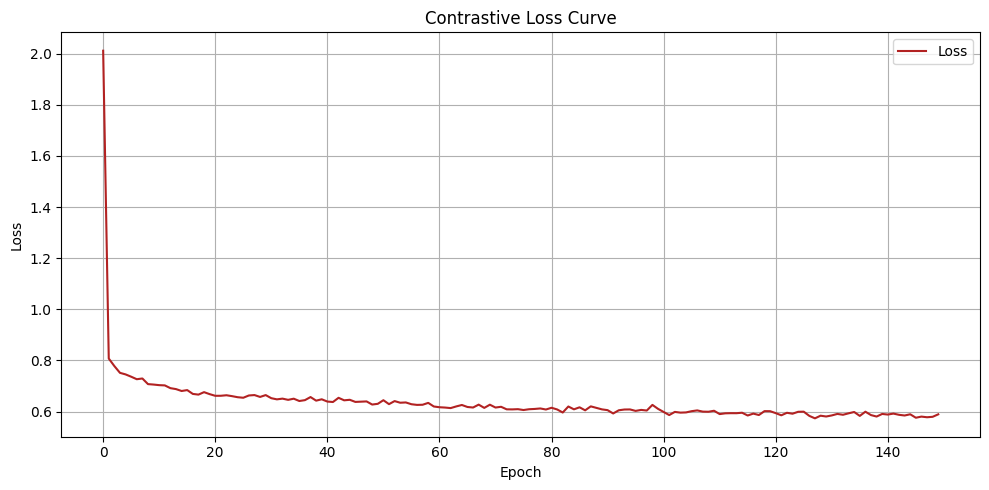

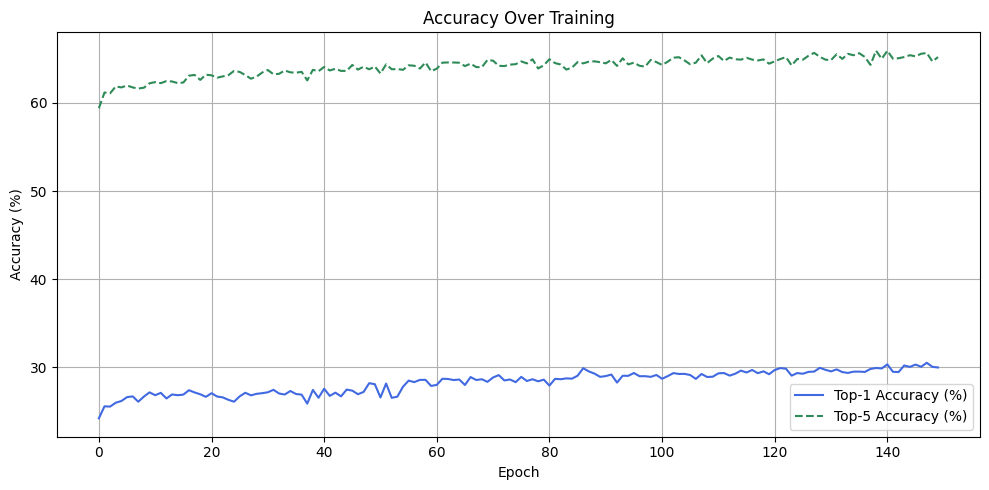

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

#  Load dataset
dataset = SingleFileEmbeddingPairDataset(
    "C:\\Users\\Z0054udc\\Downloads\\Siamese GNN\\XT_merged_doubled.json"
)
print(f"Found {len(dataset)} dataset entries.")
if len(dataset) == 0:
    raise ValueError("ERROR: No JSON files found!")

#  Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

#  Model and optimizer
model = SiameseGNN(in_dim=15, hidden_dim=64, out_dim=32).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)


#  Training hyperparameters
epochs = 150
grad_accum_steps = 8        # Simulates batch size = 8
loss_history, top1_history, top5_history = [], [], []

#  Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    total_top1 = 0.0
    total_top5 = 0.0
    num_acc = 0
    optimizer.zero_grad()

    for i in tqdm(range(len(dataset)), desc=f"Epoch {epoch+1}"):
        data1, data2, matches = dataset[i]
        data1, data2, matches = data1.to(device), data2.to(device), matches.to(device)

        # Forward pass for this pair
        emb1, emb2 = model(data1, data2)
        matches_pos = matches[(matches[:, 0] != -1) & (matches[:, 1] != -1)]
        matches_neg = get_mixed_negatives(emb1, emb2, matches_pos, ratio=0.5, top_k=3)
        loss = contrastive_margin_loss(emb1, emb2, matches_pos, matches_neg)
        loss.backward()

        total_loss += loss.item()

        # --- Accuracy tracking
        acc1 = batch_accuracy(emb1, emb2, matches)
        acc5 = batch_topk_accuracy(emb1, emb2, matches, k=5)
        if acc1 is not None and acc5 is not None:
            total_top1 += acc1
            total_top5 += acc5
            num_acc += 1

        # --- Gradient accumulation ---
        if (i + 1) % grad_accum_steps == 0 or (i + 1) == len(dataset):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()
            optimizer.zero_grad()

    # ---- Epoch summary ----
    avg_loss = total_loss / len(dataset)
    avg_top1 = (total_top1 / num_acc) * 100 if num_acc > 0 else 0.0
    avg_top5 = (total_top5 / num_acc) * 100 if num_acc > 0 else 0.0

    loss_history.append(avg_loss)
    top1_history.append(avg_top1)
    top5_history.append(avg_top5)

    print(f"Epoch {epoch+1:03d}: Loss = {avg_loss:.4f}, Top-1 = {avg_top1:.2f}%, Top-5 = {avg_top5:.2f}%")

# ✅ Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Loss", color='firebrick')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Contrastive Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(top1_history, label="Top-1 Accuracy (%)", color='royalblue')
plt.plot(top5_history, label="Top-5 Accuracy (%)", linestyle="--", color='seagreen')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [65]:
torch.save(model.state_dict(), "siamese_gnn.pth")
# To load: model.load_state_dict(torch.load("siamese_gnn.pth"))